In [3]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-29i65_v1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-29i65_v1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


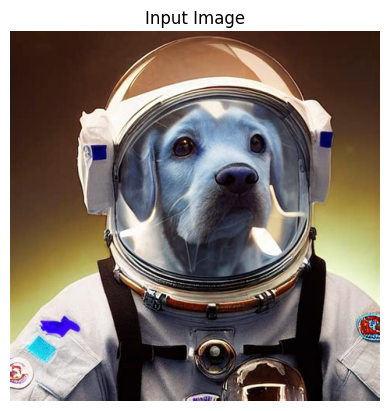


Top Matching Descriptions:
An astronaut dog: 99.90%
An astronaut: 0.09%
A dog: 0.01%


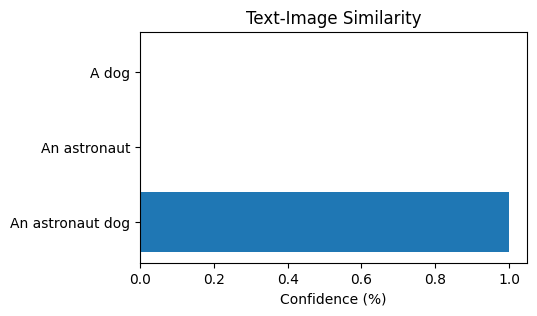

In [4]:
import torch
import clip
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import cv2
import os


# ----------------------------
# 1. LOAD PRETRAINED CLIP MODEL
# 1. CARICA IL MODELLO CLIP PRE-ADDESTRATO
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# ----------------------------
# 2. LOAD IMAGE FROM URL OR LOCAL
# 2. CARICA IMMAGINE DA URL O LOCALE
# ----------------------------
'''
1. Load image from URL
url = "https://www.w3schools.com/w3images/fjords.jpg"  # Example image
response = requests.get(url)
image = Image.open(BytesIO(response.content))'
'''


#2. Load image from local file
image = cv2.imread(os.path.join(os.getcwd(), 'clip_imgs','doggo.webp'))
image = Image.fromarray(image.astype('uint8'), 'RGB')
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()


# Preprocess the image
image_input = preprocess(image).unsqueeze(0).to(device)

# ----------------------------
# 3. CREATE TEXT PROMPTS
# 3. CREA I PROMPT TESTUALI
# ----------------------------
texts = [
    "A dog",
    "An astronaut",
    "A car",
    "Some keys",
    "An astronaut dog"
]

# Tokenize text
text_inputs = clip.tokenize(texts).to(device)

# ----------------------------
# 4. MAKE PREDICTIONS
# 4. FAI LE PREDIZIONI
# ----------------------------
with torch.no_grad():
    # Encode image and text into embeddings
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

    # Normalize to unit length (improves cosine similarity)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute similarity (cosine similarity)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(3)  # Top 3 matches

# ----------------------------
# 5. DISPLAY RESULTS
# 6. MOSTRA RISULTATI
# ----------------------------
print("\nTop Matching Descriptions:")
for value, index in zip(values, indices):
    print(f"{texts[index]}: {value.item()*100:.2f}%")

# Plot results
plt.figure(figsize=(5, 3))
plt.barh([texts[i] for i in indices.cpu().numpy()], values.cpu().numpy())
plt.title("Text-Image Similarity")
plt.xlabel("Confidence (%)")
plt.show()
